# Laboratorio # — Transfer Learning (VGG16 + CIFAR-10)

**Integrantes:** Gabriel Paz - Diedrich Solis  
**Objetivo:** Evaluar el desempeño del modelo preentrenado **VGG16** sobre **CIFAR‑10** bajo tres configuraciones:
1) **Sin entrenamiento adicional**  
2) **Feature Extraction**  
3) **Fine‑Tuning**

## 1) Investigación y contexto

### VGG16
- Arquitectura con **16 capas** con pesos (13 conv + 3 FC). Convoluciones **3×3**, *stride* 1, *padding* 1; *max‑pool* 2×2.  
- Entrada esperada **224×224 RGB**.  
- **~138M** parámetros.  
- Preentrenado en **ImageNet** (≈1.2M imágenes, 1,000 clases).  
- **Adaptación a un nuevo problema:** sustituir la última capa del `classifier` por una con el **número de clases** del nuevo dataset; ajustar normalización a las estadísticas de ImageNet; re‑dimensionar imágenes a 224×224.

### Dataset CIFAR‑10
- **60,000** imágenes **32×32 RGB**; **10 clases**.  
- **50k** train / **10k** test.  
- Para compatibilidad con VGG16:  
  - *Resize* a **224×224**.  
  - Convertir a tensor y **normalizar** con medias y desviaciones de **ImageNet**:  
    `mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`.

> En este notebook separamos **train/val** (validación) a partir del conjunto de entrenamiento (90%/10%) para trazar las curvas solicitadas, y preservamos **test** para el reporte final.


## 2) Entorno, librerías y configuración

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np, time, copy, pandas as pd, random, os

print('torch:', torch.__version__, '| torchvision:', torchvision.__version__)
print('CUDA available:', torch.cuda.is_available())

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

torch: 2.8.0+cu126 | torchvision: 0.23.0+cu126
CUDA available: True


device(type='cuda')

## 3) Hiperparámetros

In [2]:
BATCH_SIZE = 64
EPOCHS_FE = 8      # Feature Extraction
EPOCHS_FT = 8      # Fine-Tuning
LR_FE = 1e-4       # LR para clasificador
LR_FT = 1e-5       # LR reducida para fine-tuning
VAL_SPLIT = 0.1
NUM_WORKERS = 2 if os.name != 'nt' else 0

BATCH_SIZE, EPOCHS_FE, EPOCHS_FT, LR_FE, LR_FT

(64, 8, 8, 0.0001, 1e-05)

## 4) Datos: transformaciones, carga y separación Train/Val/Test

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set   = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_eval)

val_size = int(len(train_full) * VAL_SPLIT)
train_size = len(train_full) - val_size
train_set, val_set = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

len(train_set), len(val_set), len(test_set)

100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s]


(45000, 5000, 10000)

## 5) Utilidades: entrenamiento, evaluación y gráficos

In [4]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            _, preds = out.max(1)
            running_loss += loss.item() * x.size(0)
            running_corrects += (preds == y).sum().item()
            total += y.size(0)
    return running_loss/total, running_corrects/total

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None):
    best_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        tr_loss, tr_corrects, tr_total = 0.0, 0, 0

        start = time.time()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            _, preds = out.max(1)
            tr_loss += loss.item() * x.size(0)
            tr_corrects += (preds == y).sum().item()
            tr_total += y.size(0)

        if scheduler is not None:
            scheduler.step()

        train_loss = tr_loss / tr_total
        train_acc  = tr_corrects / tr_total
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        elapsed = time.time() - start
        print(f"Epoch {epoch+1}/{epochs} | Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f} | {elapsed:.1f}s")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_wts)
    return model, history, best_val_acc

def plot_curve(values, title, ylabel):
    import matplotlib.pyplot as plt
    plt.figure()
    for label, series in values.items():
        plt.plot(range(1, len(series)+1), series, label=label)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## 6) Experimentos

### a) Evaluación **sin entrenamiento adicional** (baseline)

In [5]:
model_a = models.vgg16(weights='IMAGENET1K_V1')
model_a.classifier[6] = nn.Linear(4096, 10)
model_a = model_a.to(device)

crit = nn.CrossEntropyLoss()
test_loss_a, test_acc_a = evaluate(model_a, test_loader, crit)
print(f"Baseline (sin entrenamiento) — Test Loss: {test_loss_a:.4f} | Test Acc: {test_acc_a:.4f}")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 81.1MB/s]


Baseline (sin entrenamiento) — Test Loss: 2.3840 | Test Acc: 0.0592


### b) **Feature Extraction** (congelar convoluciones, entrenar clasificador)

In [6]:
model_b = models.vgg16(weights='IMAGENET1K_V1')
for p in model_b.features.parameters():
    p.requires_grad = False
model_b.classifier[6] = nn.Linear(4096, 10)
model_b = model_b.to(device)

crit_b = nn.CrossEntropyLoss()
optim_b = optim.Adam(model_b.classifier[6].parameters(), lr=LR_FE)
model_b, hist_b, best_val_acc_b = train_model(model_b, train_loader, val_loader, crit_b, optim_b, EPOCHS_FE)
test_loss_b, test_acc_b = evaluate(model_b, test_loader, crit_b)
print(f"Feature Extraction — Best Val Acc: {best_val_acc_b:.4f} | Test Loss: {test_loss_b:.4f} | Test Acc: {test_acc_b:.4f}")

Epoch 1/8 | Train Loss 0.9247 Acc 0.7104 | Val Loss 0.6237 Acc 0.7960 | 253.7s
Epoch 2/8 | Train Loss 0.6251 Acc 0.7848 | Val Loss 0.5509 Acc 0.8048 | 253.9s
Epoch 3/8 | Train Loss 0.5822 Acc 0.7976 | Val Loss 0.5191 Acc 0.8188 | 254.0s
Epoch 4/8 | Train Loss 0.5595 Acc 0.8063 | Val Loss 0.5043 Acc 0.8220 | 254.0s
Epoch 5/8 | Train Loss 0.5458 Acc 0.8080 | Val Loss 0.4900 Acc 0.8256 | 254.4s
Epoch 6/8 | Train Loss 0.5297 Acc 0.8149 | Val Loss 0.4847 Acc 0.8268 | 254.4s
Epoch 7/8 | Train Loss 0.5256 Acc 0.8163 | Val Loss 0.4690 Acc 0.8348 | 254.4s
Epoch 8/8 | Train Loss 0.5194 Acc 0.8166 | Val Loss 0.4753 Acc 0.8296 | 254.5s
Feature Extraction — Best Val Acc: 0.8348 | Test Loss: 0.4876 | Test Acc: 0.8322


#### Gráficas — Feature Extraction

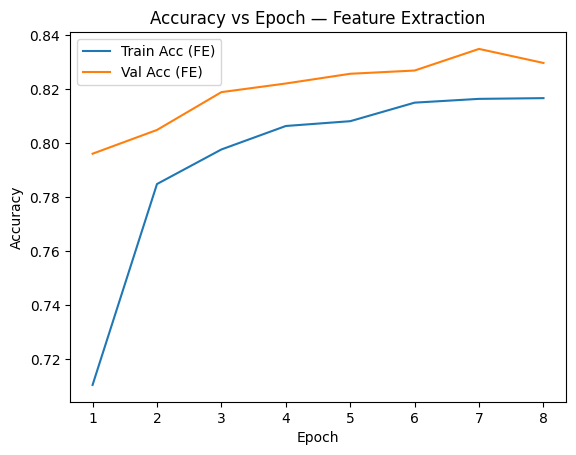

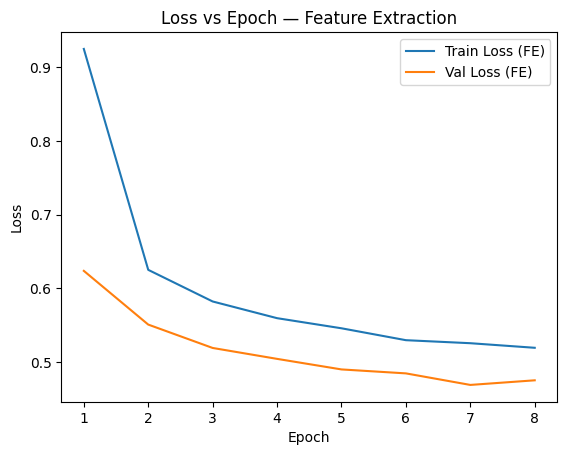

In [7]:
plot_curve({'Train Acc (FE)': hist_b['train_acc'], 'Val Acc (FE)': hist_b['val_acc']},
           'Accuracy vs Epoch — Feature Extraction', 'Accuracy')
plot_curve({'Train Loss (FE)': hist_b['train_loss'], 'Val Loss (FE)': hist_b['val_loss']},
           'Loss vs Epoch — Feature Extraction', 'Loss')

### c) **Fine‑Tuning** (entrenar todo el modelo con LR reducida)

In [8]:
model_c = models.vgg16(weights='IMAGENET1K_V1')
model_c.classifier[6] = nn.Linear(4096, 10)
model_c = model_c.to(device)

crit_c = nn.CrossEntropyLoss()
optim_c = optim.Adam(model_c.parameters(), lr=LR_FT)
scheduler_c = optim.lr_scheduler.StepLR(optim_c, step_size=3, gamma=0.8)
model_c, hist_c, best_val_acc_c = train_model(model_c, train_loader, val_loader, crit_c, optim_c, EPOCHS_FT, scheduler_c)
test_loss_c, test_acc_c = evaluate(model_c, test_loader, crit_c)
print(f"Fine-Tuning — Best Val Acc: {best_val_acc_c:.4f} | Test Loss: {test_loss_c:.4f} | Test Acc: {test_acc_c:.4f}")

Epoch 1/8 | Train Loss 0.6156 Acc 0.7862 | Val Loss 0.2824 Acc 0.9018 | 659.2s
Epoch 2/8 | Train Loss 0.2683 Acc 0.9106 | Val Loss 0.2422 Acc 0.9164 | 660.0s
Epoch 3/8 | Train Loss 0.1936 Acc 0.9344 | Val Loss 0.2271 Acc 0.9230 | 660.4s
Epoch 4/8 | Train Loss 0.1409 Acc 0.9517 | Val Loss 0.1923 Acc 0.9308 | 660.4s
Epoch 5/8 | Train Loss 0.1105 Acc 0.9628 | Val Loss 0.1760 Acc 0.9420 | 660.6s
Epoch 6/8 | Train Loss 0.0841 Acc 0.9719 | Val Loss 0.1833 Acc 0.9388 | 661.0s
Epoch 7/8 | Train Loss 0.0585 Acc 0.9808 | Val Loss 0.2002 Acc 0.9374 | 661.4s
Epoch 8/8 | Train Loss 0.0465 Acc 0.9848 | Val Loss 0.1895 Acc 0.9404 | 661.1s
Fine-Tuning — Best Val Acc: 0.9420 | Test Loss: 0.1973 | Test Acc: 0.9333


#### Gráficas — Fine‑Tuning

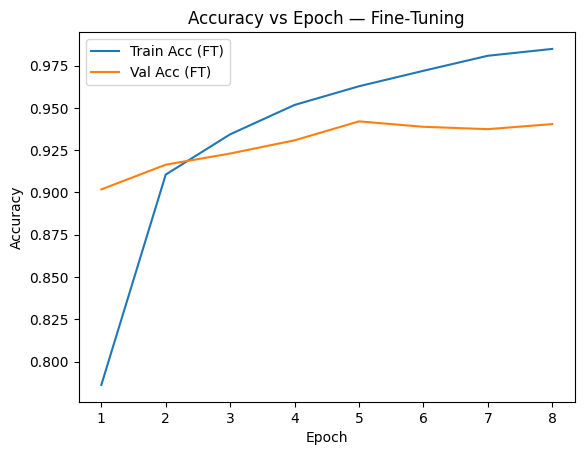

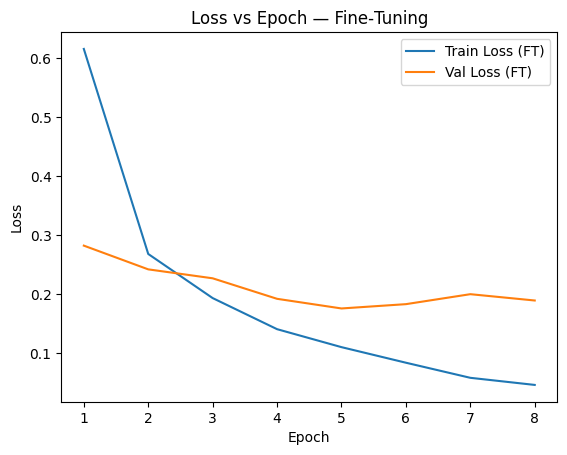

In [9]:
plot_curve({'Train Acc (FT)': hist_c['train_acc'], 'Val Acc (FT)': hist_c['val_acc']},
           'Accuracy vs Epoch — Fine‑Tuning', 'Accuracy')
plot_curve({'Train Loss (FT)': hist_c['train_loss'], 'Val Loss (FT)': hist_c['val_loss']},
           'Loss vs Epoch — Fine‑Tuning', 'Loss')

## 7) Tabla comparativa de resultados

In [10]:
tabla = pd.DataFrame([
    {'Configuración': 'Sin entrenamiento', 'Train Acc': np.nan, 'Val Acc': np.nan, 'Test Acc': test_acc_a, 'Test Loss': test_loss_a},
    {'Configuración': 'Feature Extraction', 'Train Acc': hist_b['train_acc'][-1], 'Val Acc': hist_b['val_acc'][-1], 'Test Acc': test_acc_b, 'Test Loss': test_loss_b},
    {'Configuración': 'Fine-Tuning', 'Train Acc': hist_c['train_acc'][-1], 'Val Acc': hist_c['val_acc'][-1], 'Test Acc': test_acc_c, 'Test Loss': test_loss_c},
])
tabla.style.format({'Train Acc': '{:.4f}', 'Val Acc': '{:.4f}', 'Test Acc': '{:.4f}', 'Test Loss': '{:.4f}'})

,Configuración,Train Acc,Val Acc,Test Acc,Test Loss
0,Sin entrenamiento,nan,nan,0.0592,2.3840
1,Feature Extraction,0.8166,0.8296,0.8322,0.4876
2,Fine-Tuning,0.9848,0.9404,0.9333,0.1973


## 8) Análisis y discusión

- **Mejor rendimiento general:** usualmente **Fine‑Tuning**.
- **Diferencias FE vs FT:** *Feature Extraction* es más **rápido** y requiere menos datos; *Fine‑Tuning* ajusta todo el modelo y suele alcanzar **mayor accuracy**.
- **Eficiencia:** *Feature Extraction* entrena muchos menos parámetros (solo la última capa), por lo que es **más eficiente** en tiempo; *Fine‑Tuning* es más costoso pero tiende a rendir mejor.

## 9) Referencias
- Simonyan & Zisserman (2015). *Very Deep Convolutional Networks for Large-Scale Image Recognition.*  
- PyTorch `torchvision.models.vgg16` (weights `IMAGENET1K_V1`).  
- Estadísticas de normalización de ImageNet: `mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`.